In [15]:
%load_ext autoreload
%autoreload 2

In [26]:
%matplotlib inline

import tensorflow as tf
import time
import numpy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 01_introduction_mlp.ipynb

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.
x_train = x_train.reshape(x_train.shape[0], numpy.prod(x_train[0,:,:].shape))
x_test = x_test.reshape(x_test.shape[0], numpy.prod(x_test[0,:,:].shape))
y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

In [4]:
newX_train, newX_test, newy_train, newy_test = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

### Use subset of training data set and test set

In [7]:
batch_size = 100
newX_train_batch = newX_train[:batch_size, :]
newy_train_batch = newy_train[:batch_size,numpy.newaxis]

newX_test_batch = newX_test[:batch_size, :]
newy_test_batch = newy_test[:batch_size,numpy.newaxis]

### Calculate loss and accuracy of data
To stop training, we can examine the accuracy and loss of the model.

In [12]:
def linear_model(W, input_images):
    # f(x) = xW returns m-length vector, where m is the number of examples
    return numpy.dot(input_images, W)

def evaluate(W, input_images, true_labels):
    predicted_label = linear_model(W, input_images)
    MSE = numpy.mean((true_labels - predicted_label)**2) 
    return MSE

def learn(input_images, true_labels, current_W, learning_rate=0.000001):
    # first we need dJW/dW where JW = MSE 
    n = input_images.shape[0] # get number of examples to average over
    label_predictions = linear_model(current_W, input_images)
    # calculate gradient: one entry per partial derivative for an entry in vector W
    dJW_dW = (2./n) * numpy.dot(input_images.transpose(), label_predictions - true_labels)
    # now we update W
    new_W = current_W - (learning_rate * dJW_dW)  # gradient update step
    return new_W

def accuracy(true_labels, predicted_labels):
    N = predicted_labels.shape[0]
    acc = (true_labels == predicted_labels).sum() / N
    return acc

def evaluate_accuracy(W, input_images, true_labels):
    predicted_labels = numpy.round(linear_model(W, input_images)) # round real numbers to integer labels
    acc = accuracy(true_labels, predicted_labels) 
    return acc

In [13]:
num_features = x_train.shape[1] # this is the number of pixels

# Randomly initialize W
W = .01 * numpy.random.rand(num_features,1)

# now iterate num_iters times, with the step size defined by learning_rate
learning_rate = 0.0005  
num_iters = 5000
lossTrain = numpy.zeros(num_iters,)       # loss of Training Data
lossVal = numpy.zeros(num_iters,)      # Loss of Validation Data
accuracyTrain = numpy.zeros(num_iters,)
accuracyVal = numpy.zeros(num_iters,)

for i in range(0, num_iters):
    # all the magic here
    W = learn(newX_train_batch, newy_train_batch, W, learning_rate)
    lossTrain[i] = evaluate(W, newX_train_batch, newy_train_batch)
    accuracyTrain[i] = evaluate_accuracy(W, newX_train_batch, newy_train_batch)
    
    W = learn(newX_test_batch, newy_test_batch, W, learning_rate)
    lossVal[i] = evaluate(W, newX_test_batch, newy_test_batch)
    accuracyVal[i] = evaluate_accuracy(W, newX_test_batch, newy_test_batch)

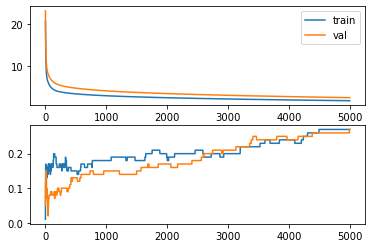

In [14]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(lossTrain)
plt.plot(lossVal)
plt.legend(["train", "val"])

plt.subplot(2,1,2)
plt.plot(accuracyTrain)
plt.plot(accuracyVal)

## 02_full_net.ipynb

In [32]:
# repeating the data prep from the previous notebook
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Split Data into Training and Validation Data subsets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

x_train = x_train.astype(numpy.float32)
x_val  = x_val.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_val  /= 255.
x_test  /= 255.

print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0], numpy.prod(x_train[0,:,:].shape))
x_val = x_val.reshape(x_val.shape[0], numpy.prod(x_val[0,:,:].shape))
x_test = x_test.reshape(x_test.shape[0], numpy.prod(x_test[0,:,:].shape))

print(x_train.shape)
y_train = y_train.astype(numpy.int32)
y_val  = y_val.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

print()
print('MNIST data loaded: train:',len(x_train),'val:',len(x_val), 'test:',len(x_test))
print('X_train:', x_train.shape)
print('y_train:', y_train.shape)

# one-hot encoding:
nb_classes = 10
y_train_onehot = tf.keras.utils.to_categorical(y_train, nb_classes)
y_val_onehot = tf.keras.utils.to_categorical(y_val, nb_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test, nb_classes)

(40200, 28, 28)
(40200, 784)

MNIST data loaded: train: 40200 val: 19800 test: 10000
X_train: (40200, 784)
y_train: (40200,)


In [33]:
# Here we import an implementation of a two-layer neural network 
# this code is based on pieces of the first assignment from Stanford's CSE231n course, 
# hosted at https://github.com/cs231n/cs231n.github.io with the MIT license
from fc_net import TwoLayerNet

In [38]:
# a simple implementation of stochastic gradient descent
def sgd(model, gradients, learning_rate):
    for p, w in model.params.items():
        dw = gradients[p]
        new_weights = w - learning_rate * dw
        model.params[p] = new_weights

# one training step
def learn(model, x_train, y_train_onehot, learning_rate):
    loss, gradients = model.loss(x_train, y_train_onehot)
    sgd(model, gradients, learning_rate)
    return loss

def accuracy(model, x, true_values):
    scores = model.loss(x)
    predictions = numpy.argmax(scores, axis=1)
    N = predictions.shape[0]
    # EDIT: squeezing true_values from 2d to 1d speeds up this function
    true_values_1d = numpy.squeeze(true_values)
    acc = (true_values_1d == predictions).sum() / N
    return acc

In [39]:
def training(learning_rate, batch_size, num_epochs, hidden_dim, weight_scale, x_train, y_train, y_train_onehot, x_val, y_val, y_val_onehot):
    num_features = x_train.shape[1] # this is the number of pixels
    nb_classes = y_train_onehot.shape[1]
    
    # The weights are initialized from a normal distribution with standard deviation weight_scale
    model = TwoLayerNet(input_dim=num_features, hidden_dim=hidden_dim, num_classes=nb_classes, weight_scale=weight_scale)
    
    num_examples_train = x_train.shape[0]
    num_batches_train = int(num_examples_train / batch_size)
    
    losses = numpy.zeros((num_batches_train*num_epochs,2)) # 1st column for training data, 2nd for validation data
    # EDIT: also track accuracy
    accuracies = numpy.zeros((num_batches_train*num_epochs,2)) 
    
    indices_train = numpy.arange(num_examples_train)
    num_examples_val = x_val.shape[0]
    indices_val = numpy.arange(num_examples_val)

    i = 0
    for epoch in range(0, num_epochs):
        start_epoch = time.time()
        # in each epoch, we loop over all of the training examples
        for step in range(0, num_batches_train):
            # grabbing the next training batch
            offset_train = step * batch_size
            batch_range_train = range(offset_train, offset_train+batch_size)
            x_train_batch = x_train[batch_range_train, :]
            # EDIT: keep around non-onehot labels as well for accuracy calculation
            y_train_onehot_batch = y_train_onehot[batch_range_train,:]
            y_train_batch = y_train[batch_range_train,numpy.newaxis]

            # one approach: grab a random validation batch (random offset into number of validation examples)
            offset_val = numpy.random.randint(low=0, high=num_examples_val-batch_size)
            batch_range_val = range(offset_val, offset_val+batch_size)
            x_val_batch = x_val[batch_range_val, :]
            y_val_onehot_batch = y_val_onehot[batch_range_val,:]
            y_val_batch = y_val[batch_range_val,numpy.newaxis]

            # feed the next batch in to do one sgd step
            loss_train = learn(model, x_train_batch, y_train_onehot_batch, learning_rate)

            # check training & validation loss & accuracy
            losses[i,0] = loss_train
            
            # could save time by commenting out the next three lines and only tracking at the epoch level
            accuracies[i,0] = accuracy(model, x_train_batch, y_train_batch)
            losses[i,1], _ = model.loss(x_val_batch, y_val_onehot_batch)
            accuracies[i,1] = accuracy(model, x_val_batch, y_val_batch)
            i += 1

        # slower, so we're only doing this once per epoch: checking accuracy on all of the data at once
        acc_train = accuracy(model, x_train, y_train)
        acc_val = accuracy(model, x_val, y_val)
        
        # reshuffle the data so that we get a new set of batches
        numpy.random.shuffle(indices_train)
        x_train = x_train[indices_train,:]
        y_train = y_train[indices_train] # keep this shuffled the same way for use in accuracy calculation
        y_train_onehot = y_train_onehot[indices_train,:]

        numpy.random.shuffle(indices_val)
        x_val = x_val[indices_val,:]
        y_val = y_val[indices_val] 
        y_val_onehot = y_val_onehot[indices_val,:]
        end_epoch = time.time()
        time_this_epoch = end_epoch - start_epoch
        print("epoch %d took %.1f seconds, training loss %.5f (last batch), training accuracy %.3f, validation accuracy %.3f" % (epoch, time_this_epoch, loss_train, acc_train, acc_val))
    return losses, accuracies, model

epoch 0 took 7.9 seconds, training loss 2.30146 (last batch), training accuracy 0.122, validation accuracy 0.118
epoch 1 took 7.6 seconds, training loss 2.30035 (last batch), training accuracy 0.141, validation accuracy 0.139
epoch 2 took 7.8 seconds, training loss 2.29934 (last batch), training accuracy 0.162, validation accuracy 0.161
epoch 3 took 7.4 seconds, training loss 2.29825 (last batch), training accuracy 0.184, validation accuracy 0.182
epoch 4 took 7.7 seconds, training loss 2.29734 (last batch), training accuracy 0.206, validation accuracy 0.203
epoch 5 took 7.4 seconds, training loss 2.29646 (last batch), training accuracy 0.228, validation accuracy 0.226
epoch 6 took 7.6 seconds, training loss 2.29527 (last batch), training accuracy 0.255, validation accuracy 0.250
epoch 7 took 7.2 seconds, training loss 2.29421 (last batch), training accuracy 0.284, validation accuracy 0.279
epoch 8 took 7.7 seconds, training loss 2.29292 (last batch), training accuracy 0.311, validatio

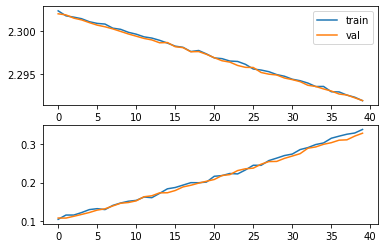

In [40]:
# these are the hyperparameters we had in class
learning_rate = 0.01  
batch_size = 10000
num_epochs = 10
hidden_dim = 300
weight_scale = .01
losses, accuracies, model = training(learning_rate, batch_size, num_epochs, hidden_dim, weight_scale, x_train, y_train, y_train_onehot, x_val, y_val, y_val_onehot)

# EDIT: plot training & val, loss & accuracy
plt.figure()
plt.subplot(2,1,1)
plt.plot(losses[:,0])
plt.plot(losses[:,1])
plt.legend(["train", "val"])

plt.subplot(2,1,2)
plt.plot(accuracies[:,0])
plt.plot(accuracies[:,1])

# Homework: improve the accuracy of this model. 

Update this notebook so that the accuracy is improved. How high can you get it? You could change things directly in the notebook, such as increasing the number of epochs, changing the learning weight, changing the width of the hidden layer, etc. If you're more ambitious, you could also try changing the model definition itself by checking out the associated Python files. For example, you could add more layers to the network. The current notebook has a training accuracy of about 43%, but will vary with randomness.

0.03210479558034334
epoch 0 took 33.9 seconds, training loss 0.68807 (last batch), training accuracy 0.850, validation accuracy 0.850
epoch 1 took 35.5 seconds, training loss 0.52536 (last batch), training accuracy 0.878, validation accuracy 0.879
epoch 2 took 33.0 seconds, training loss 0.42956 (last batch), training accuracy 0.890, validation accuracy 0.892
epoch 3 took 36.9 seconds, training loss 0.38361 (last batch), training accuracy 0.897, validation accuracy 0.899
epoch 4 took 38.2 seconds, training loss 0.34662 (last batch), training accuracy 0.902, validation accuracy 0.906
epoch 5 took 32.3 seconds, training loss 0.34794 (last batch), training accuracy 0.906, validation accuracy 0.909
epoch 6 took 32.7 seconds, training loss 0.31148 (last batch), training accuracy 0.910, validation accuracy 0.912
epoch 7 took 32.5 seconds, training loss 0.36999 (last batch), training accuracy 0.913, validation accuracy 0.916
epoch 8 took 31.6 seconds, training loss 0.31686 (last batch), train

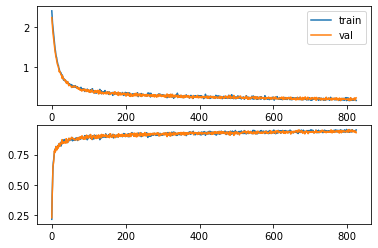

In [41]:
learning_rate = 0.1  
batch_size = 1200
num_epochs = 25
hidden_dim = 1600

size_input = x_train.shape[1]
weight_scale1 = numpy.sqrt(2./(size_input+hidden_dim))
weight_scale2 = numpy.sqrt(2./(hidden_dim+nb_classes))
weight_scale = (weight_scale1 + weight_scale2)/2
print(weight_scale)
losses, accuracies, model = training(learning_rate, batch_size, num_epochs, hidden_dim, weight_scale, x_train, y_train, y_train_onehot, x_val, y_val, y_val_onehot)

plt.figure()
plt.subplot(2,1,1)
plt.plot(losses[:,0])
plt.plot(losses[:,1])
plt.legend(["train", "val"])

plt.subplot(2,1,2)
plt.plot(accuracies[:,0])
plt.plot(accuracies[:,1])